# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Описание данных
airports_nearest — расстояние до ближайшего аэропорта в метрах (м)  
balcony — число балконов  
ceiling_height — высота потолков (м)  
cityCenters_nearest — расстояние до центра города (м)  
days_exposition — сколько дней было размещено объявление (от публикации до снятия)  
first_day_exposition — дата публикации  
floor — этаж  
floors_total — всего этажей в доме  
is_apartment — апартаменты (булев тип)  
kitchen_area — площадь кухни в квадратных метрах (м²)  
last_price — цена на момент снятия с публикации  
living_area — жилая площадь в квадратных метрах(м²)  
locality_name — название населённого пункта  
open_plan — свободная планировка (булев тип)  
parks_around3000 — число парков в радиусе 3 км  
parks_nearest — расстояние до ближайшего парка (м)  
ponds_around3000 — число водоёмов в радиусе 3 км  
ponds_nearest — расстояние до ближайшего водоёма (м)  
rooms — число комнат  
studio — квартира-студия (булев тип)  
total_area — площадь квартиры в квадратных метрах (м²)  
total_images — число фотографий квартиры в объявлении

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Шаг2. Предобработка данных
Постепенно обработаем все переменные с пропусками

**ceiling_height — высота потолков (м)**  

False    14504
True      9195
Name: ceiling_height, dtype: int64
--------------
Пропущеных значений: 38.8%
--------------
count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


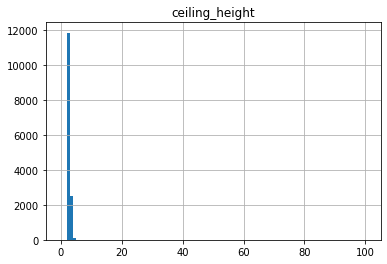

In [3]:
ceiling_height_isna = df['ceiling_height'].isna().value_counts()
print(ceiling_height_isna)
print('--------------')
print('Пропущеных значений: {:.1%}'.format(ceiling_height_isna.loc[True]/len(df)))
print('--------------')
print(df['ceiling_height'].describe())
df.hist('ceiling_height', range = (0,100), bins = 100);

Неивестныйх значений много и явно есть проблемы с достоверностью данных на концах распеределения. Максимальное значение 100 метров.  
Сомнительная высота, в минимуме похожая история. В среднем высота похожа на реальную. 
Сегодня минимальной нормой в России считается высота потолка 2,4 метра. В новостройках обычно это значение находится в пределах 2,5-2,7 метра. Для элитного жилья показатель может превышать 3 метра.  
Можно допусть что есть и 2 этажные квартиры и потолки самой элитной группы недвижимости могут доходить до 5 метров на этаж, те в сумме 10 метров.  
Исследуем более детельно исследовать перед тем как принять решение по замене.

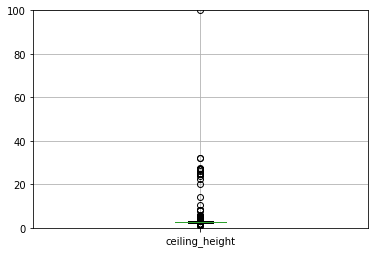

In [4]:
plt.ylim(0 , 100)
df.boxplot('ceiling_height');

На графике видно, что есть выбросы со смещением в сторону ультра высоких потолков. Построим гисторграммы и поймем как обстоят дела на концах распределения.

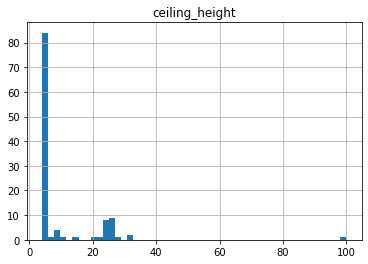

In [5]:
df.hist('ceiling_height', range = (4,100), bins = 50);

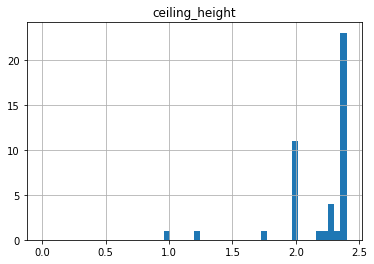

In [6]:
df.hist('ceiling_height', range = (0,2.4), bins = 50);

На графиках видно, что есть квартиры с аномально большой и маленькой высотой потолка.  
Данныех не много и я бы от них избавился прям сейчас, но наверное стоит посмотреть более детально и найти хоть какие нибудь закономерности или критерии избавления.  
Сделаем срезы и изучим данные.

In [7]:
pd.options.display.max_columns = None
ceiling_height_big = df.query('ceiling_height > 10').sort_values(by='ceiling_height', ascending=False)
ceiling_height_big

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,False,False,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,False,False,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.5,24.0,37.7,19,False,False,False,11.0,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
22938,14,4000000.0,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,False,False,9.0,1.0,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0
17857,1,3900000.0,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,False,False,NaN,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,False,False,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,False,False,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
21824,20,2450000.0,44.0,2019-02-12T00:00:00,2,27.0,2.0,38.0,2,False,False,False,8.6,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN


                last_price  total_area     rooms  ceiling_height
last_price        1.000000    0.146424 -0.105686        0.682081
total_area        0.146424    1.000000  0.728968       -0.230816
rooms            -0.105686    0.728968  1.000000       -0.153276
ceiling_height    0.682081   -0.230816 -0.153276        1.000000


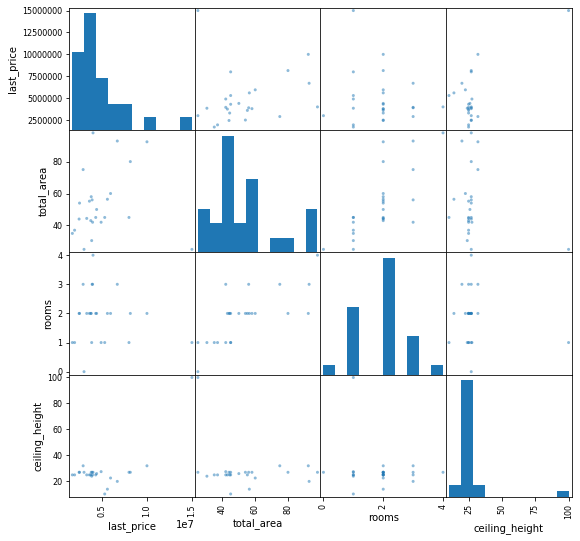

In [8]:
print(ceiling_height_big[['last_price', 'total_area', 'rooms', 'ceiling_height']].corr())
pd.plotting.scatter_matrix(ceiling_height_big[['last_price', 'total_area', 'rooms', 'ceiling_height']], figsize=(9, 9));

                last_price  total_area     rooms  ceiling_height
last_price        1.000000    0.713078  0.401861        0.379228
total_area        0.713078    1.000000  0.761109        0.458143
rooms             0.401861    0.761109  1.000000        0.281106
ceiling_height    0.379228    0.458143  0.281106        1.000000


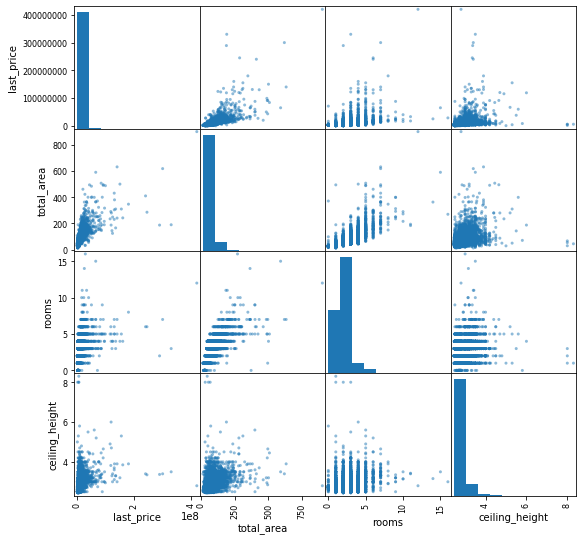

In [9]:
ceiling_height_norm = (df
                       .query('ceiling_height > 2.4 and ceiling_height < 10')
                       .sort_values(by='ceiling_height', ascending=False)
                      )
print(ceiling_height_norm[['last_price', 'total_area', 'rooms', 'ceiling_height']].corr())
pd.plotting.scatter_matrix(ceiling_height_norm[['last_price', 'total_area', 'rooms', 'ceiling_height']], figsize=(9, 9));

In [30]:
ceiling_height_big[['last_price', 'total_area', 'rooms', 'ceiling_height']].describe()

,last_price,total_area,rooms,ceiling_height
count,2.500000e+01,25.000000,25.000000,25.000000
mean,4.917960e+06,53.232000,1.880000,27.976000
std,2.906094e+06,20.241906,0.881287,15.691937
min,1.700000e+06,25.000000,0.000000,10.300000
25%,3.300000e+06,42.000000,1.000000,25.000000
50%,3.950000e+06,45.000000,2.000000,26.000000
75%,5.600000e+06,58.000000,2.000000,27.000000
max,1.500000e+07,98.000000,4.000000,100.000000


In [39]:
ceiling_height_sample = (df
    .query('ceiling_height > 2.4 and ceiling_height < 2.8')
    .sort_values(by='ceiling_height', ascending=False)
)
ceiling_height_sample[['last_price', 'total_area', 'rooms', 'ceiling_height']].describe()

,last_price,total_area,rooms,ceiling_height
count,1.039200e+04,10392.000000,10392.000000,10392.000000
mean,4.836095e+06,52.707621,1.962856,2.595025
std,2.948514e+06,20.826696,0.915844,0.090528
min,1.219000e+04,12.000000,0.000000,2.450000
25%,3.300000e+06,38.400000,1.000000,2.500000
50%,4.300000e+06,48.000000,2.000000,2.600000
75%,5.600000e+06,61.900000,3.000000,2.700000
max,8.800000e+07,422.200000,9.000000,2.790000


In [10]:
ceiling_height_little = df.query('ceiling_height < 2.4').sort_values(by='ceiling_height', ascending=False)
ceiling_height_little

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
227,13,2200000.0,47.00,2018-01-12T00:00:00,3,2.34,5.0,NaN,1,NaN,False,False,NaN,NaN,посёлок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,45.0
5498,17,2200000.0,56.00,2018-04-02T00:00:00,2,2.30,5.0,45.000000,1,NaN,False,False,9.00,2.0,Сясьстрой,NaN,NaN,NaN,NaN,NaN,NaN,55.0
17762,20,2300000.0,54.30,2018-06-28T00:00:00,3,2.30,5.0,39.000000,2,NaN,False,False,5.30,1.0,деревня Бегуницы,NaN,NaN,NaN,NaN,NaN,NaN,189.0
23498,7,1600000.0,54.00,2016-12-26T00:00:00,2,2.30,1.0,33.000000,1,False,False,False,3.50,0.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,281.0
1582,4,4100000.0,45.60,2016-01-13T00:00:00,2,2.30,9.0,28.400000,8,False,False,False,7.00,2.0,Санкт-Петербург,49152.0,14977.0,1.0,489.0,1.0,525.0,329.0
17794,1,2300000.0,58.60,2016-05-12T00:00:00,3,2.25,5.0,44.100002,3,False,False,False,5.50,1.0,деревня Бегуницы,NaN,NaN,NaN,NaN,NaN,NaN,45.0
12755,2,1400000.0,22.50,2017-09-21T00:00:00,1,2.20,2.0,18.000000,2,NaN,False,False,4.50,1.0,село Копорье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.600000,9,NaN,False,False,8.80,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
22960,17,2300000.0,53.60,2018-10-18T00:00:00,2,2.00,2.0,19.000000,1,NaN,False,False,10.00,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20520,9,3600000.0,38.00,2018-07-05T00:00:00,1,2.00,12.0,15.000000,9,NaN,False,False,11.80,1.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,62.0


**floors_total — всего этажей в доме**

False    23613
True        86
Name: floors_total, dtype: int64
count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f856e52db10>]],
      dtype=object)

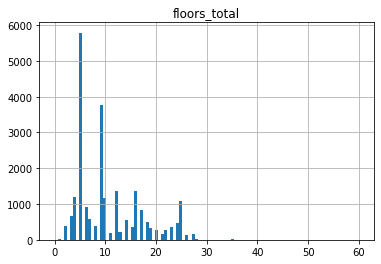

In [11]:
print(df['floors_total'].isna().value_counts())
print(df['floors_total'].describe())
df.hist('floors_total', range = (0,60), bins = 100)

Значений с пропусками мало, похоже на человеческий фактор. 
Я бы оставил пропуски, 
При заполнеение люди могли не знать или забыть сколько этажей в доме.

**living_area — жилая площадь в квадратных метрах(м²)**

False    21796
True      1903
Name: living_area, dtype: int64
Процент пропущеных значений:  8
count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f856ec0ad50>]],
      dtype=object)

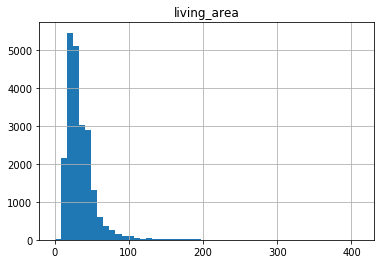

In [12]:
print(df['living_area'].isna().value_counts())
print('Процент пропущеных значений: ', round(1903*100/len(df)))
print(df['living_area'].describe())
df.hist('living_area', range = (0,410), bins = 50)

Заменим недостающие значения средним. Тип данных вещественный

False    23699
Name: living_area, dtype: int64
count    23699.000000
mean        34.457222
std         21.127391
min          2.000000
25%         19.000000
50%         31.100000
75%         41.100000
max        409.700000
Name: living_area, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8569dce0d0>]],
      dtype=object)

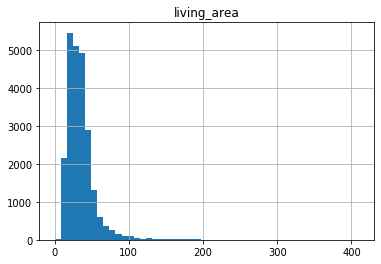

In [13]:
df.loc[df['living_area'].isna(), 'living_area'] = 34.45
print(df['living_area'].isna().value_counts())
print(df['living_area'].describe())
df.hist('living_area', range = (0,410), bins = 50)

**is_apartment — апартаменты (булев тип)**

In [14]:
print(df['is_apartment'].value_counts())
print(df['is_apartment'].isna().value_counts())

False    2725
True       50
Name: is_apartment, dtype: int64
True     20924
False     2775
Name: is_apartment, dtype: int64


In [15]:
df['is_apartment'] = df['is_apartment'].fillna('')
print(df['is_apartment'].isna().value_counts())

False    23699
Name: is_apartment, dtype: int64


Пропусков много, но мы не знаем истыные значения.   
Причины такого кол-ва пропусков сложно себе представить, на человечский фактор не спишешь.  
Возможно данные стали собирать недавно. Заполним пустыми значениями, другово выхода у нас нет.

**kitchen_area — площадь кухни в квадратных метрах (м²)**

False    21421
True      2278
Name: kitchen_area, dtype: int64
count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f856e4d2ad0>]],
      dtype=object)

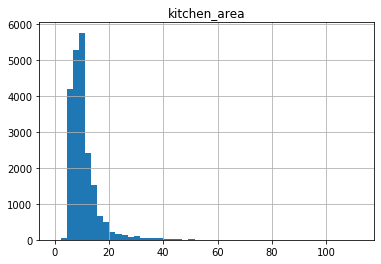

In [16]:
print(df['kitchen_area'].isna().value_counts())
print(df['kitchen_area'].describe())
df.hist('kitchen_area', range = (0,112), bins = 50)

Дополним недостающие данные средним по выборке. Тип данныз вещественный

False    23699
Name: kitchen_area, dtype: int64
count    23699.000000
mean        10.568865
std          5.614435
min          1.300000
25%          7.400000
50%         10.000000
75%         11.440000
max        112.000000
Name: kitchen_area, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f856e8b6b90>]],
      dtype=object)

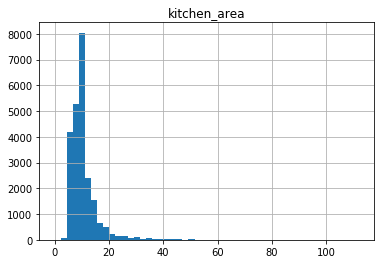

In [17]:
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = 10.56
print(df['kitchen_area'].isna().value_counts())
print(df['kitchen_area'].describe())
df.hist('kitchen_area', range = (0,112), bins = 50)

**balcony — число балконов**

In [18]:
print(df['balcony'].value_counts())
print(df['balcony'].isna().value_counts())

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64
False    12180
True     11519
Name: balcony, dtype: int64


Заменим пропуски 0, будем считать что те кто не заполнил поле просто не имеют балконов.  
Тип данных поменяем на число.

In [19]:
df.loc[df['balcony'].isna(), 'balcony'] = 0
df['balcony'] = df['balcony'].astype('int')
print(df['balcony'].value_counts())
df.info()

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around300

**locality_name — название населённого пункта**

In [20]:
print(df['locality_name'].isna().value_counts())
print(df['locality_name'].value_counts())
df['locality_name'].unique()

False    23650
True        49
Name: locality_name, dtype: int64
Санкт-Петербург                               15721
посёлок Мурино                                  522
посёлок Шушары                                  440
Всеволожск                                      398
Пушкин                                          369
                                              ...  
деревня Лаврики                                   1
садовое товарищество Новая Ропша                  1
деревня Куровицы                                  1
деревня Трубников Бор                             1
посёлок при железнодорожной станции Вещево        1
Name: locality_name, Length: 364, dtype: int64


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видим проблему связанную со написанием слов через буквы e-ё.  
Можно избавиться от обозначеня типа населенного пункта и оставить только его назавание.  
Это избавит нас от дублей и сделает более локаничным весь список.  
Напишем функцию, чтобы привести все заначения к нужному виду.

In [21]:
df.loc[df['locality_name'].isna(), 'locality_name'] = 'Неизвестно'
df.query('locality_name == "Неизвестно"').head(5)
print(df['locality_name'].isna().value_counts())

False    23699
Name: locality_name, dtype: int64


In [22]:
import re 
def save_capital_words(row):
    #меняем Ё на Е
    locality = row['locality_name'].replace('ё','е')
    #выкидываем все слова, которые не начинаются с большой буквы
    return re.sub(r'\b[а-я]+\s*', "", locality).strip()

In [23]:
df['locality_name'] = df.apply(save_capital_words , axis=1)
df['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Стало лучше)

**airports_nearest — расстояние до ближайшего аэропорта в метрах (м)**

False    18157
True      5542
Name: airports_nearest, dtype: int64
count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f856e009d10>]],
      dtype=object)

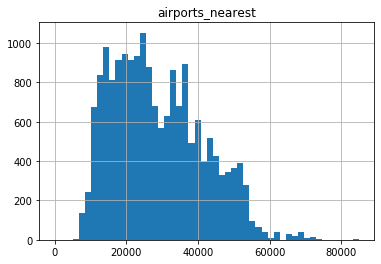

In [24]:
print(df['airports_nearest'].isna().value_counts())
print(df['airports_nearest'].describe())
df.hist('airports_nearest', range = (0,84869), bins = 50)

**cityCenters_nearest — расстояние до центра города (м)**

**parks_around3000 — число парков в радиусе 3 км**

**parks_nearest — расстояние до ближайшего парка (м)**

**ponds_around3000 — число водоёмов в радиусе 3 км** 

**ponds_nearest — расстояние до ближайшего водоёма (м)**

**days_exposition — сколько дней было размещено объявление (от публикации до снятия)**

### Исследовательский анализ данных

- [ ]  изучены следующие параметры: площадь(total_area), цена(last_price) , число комнат(rooms), высота потолков(ceiling_height)
- [ ]  построены гистограммы для каждого параметра

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f856d2f2e50>]],
      dtype=object)

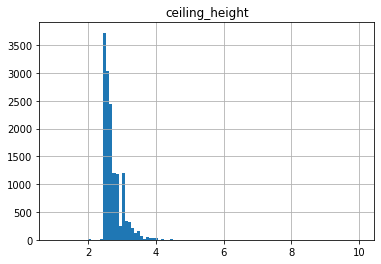

In [25]:
print(df['ceiling_height'].describe())
df.hist('ceiling_height', range = (1,10), bins = 100)

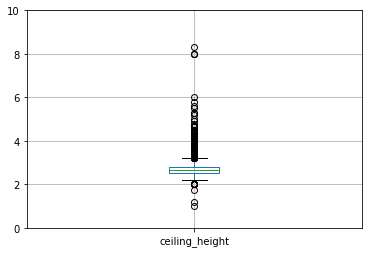

In [26]:
plt.ylim(0 , 10)
df.boxplot('ceiling_height')

На графиках видно, что есть небольшие выбробсы очень низких и высоких значений.  
Они не сильно влияют на медиану.  
Изучим их:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f856f59ce90>]],
      dtype=object)

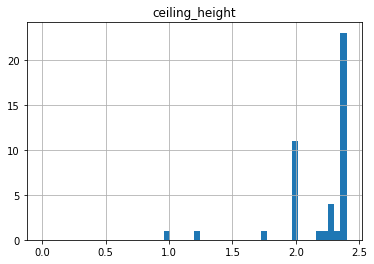

In [27]:
df.hist('ceiling_height', range = (0,2.4), bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8570c05b90>]],
      dtype=object)

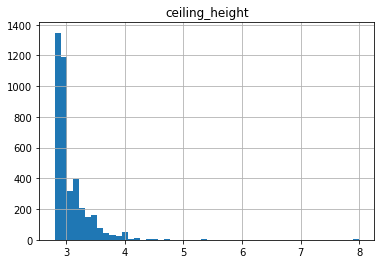

In [28]:
df.hist('ceiling_height', range = (2.8,8), bins = 50)

### Дополнительные расчеты

### Вывод

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  посчитано и добавлено в таблицу: цена квадратного метра
- [ ]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [ ]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [ ]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [ ]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [ ]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [ ]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим 